In [2]:
import os
import xml.etree.ElementTree as ET

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from mrcnn.config import Config
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.utils import compute_ap

import warnings
warnings.filterwarnings("ignore")

In [3]:
Server = True
Server = False

Train = True
Train = False

In [4]:
class KangarooDataset(Dataset):

    def load_dataset(self, dataset_dir, is_train=True):

        self.add_class("dataset", 1, "kangaroo")

        images = dataset_dir + '/images/'
        annots = dataset_dir + '/annots/'

        for filename in sorted(os.listdir(images)):
            img_id = filename[:-4]

            if img_id in ['00090']:
                continue

            if is_train and int(img_id) >= 150:
                continue

            if not is_train and int(img_id) < 150:
                continue

            img_path = images + filename
            ann_path = annots + img_id + '.xml'

            self.add_image('dataset', image_id=img_id, path=img_path, annotation=ann_path)

    def extract_bboxes(self, filename):

        tree = ET.parse(filename)
        root = tree.getroot()
        
        # extract each bounding box
        
        boxes = []
        
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
    
        return boxes, width, height

    def load_mask(self, img_id):

        info = self.image_info[img_id]
        # define bbox coords location
        path = info['annotation']
        # load XML for file
        boxes, w, h = self.extract_bboxes(path)
        masks = np.zeros([h, w, len(boxes)], dtype='uint8')
        class_ids = []

        for i in range(len(boxes)):
            box = boxes[i]
            row_min, row_max = box[1], box[3]
            col_min, col_max = box[0], box[2]

            masks[row_min:row_max, col_min:col_max, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))

        return masks, np.asarray(class_ids, dtype='uint8')

    # load an image reference
    def image_reference(self, img_id):
        info = self.image_info[img_id]
        return info['path']


In [5]:
dataset_dir = os.getcwd() + '/kangaroo'

In [6]:
# training set

train_set = KangarooDataset()
train_set.load_dataset(dataset_dir)
train_set.prepare()


In [7]:
# testing set

test_set = KangarooDataset()
test_set.load_dataset(dataset_dir, is_train=False)
test_set.prepare()

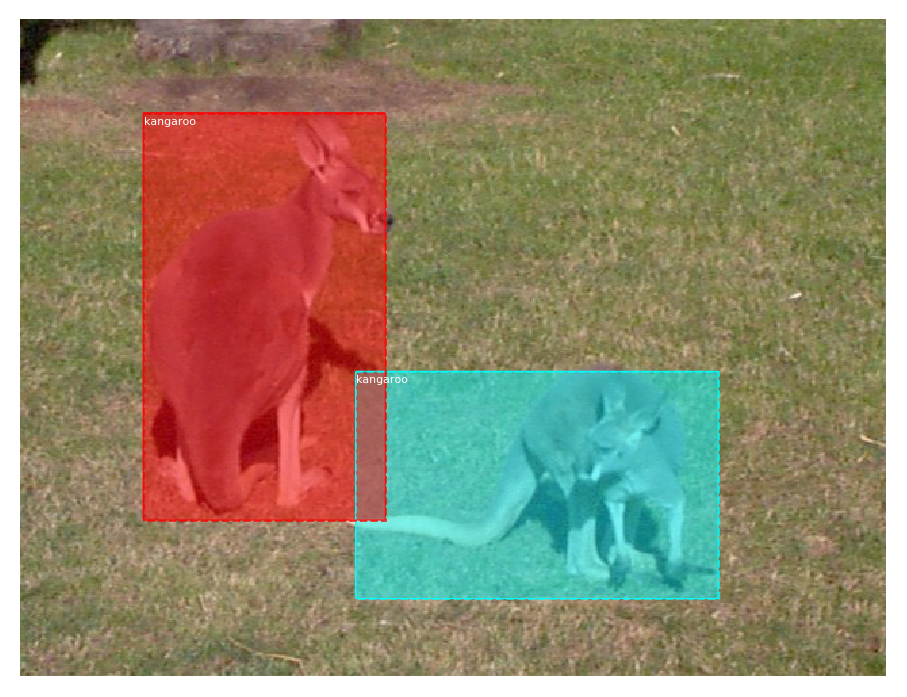

In [8]:
image_id = 21
image = train_set.load_image(image_id)
mask, class_ids = train_set.load_mask(image_id)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [9]:
class KangarooConfig(Config):
    NAME = 'kangaroo_config'
    # State number of classes inc. background
    NUM_CLASSES = 1 + 1
    LEARNING_RATE = 0.01
    STEPS_PER_EPOCH = 131

In [10]:
# prepare config

config = KangarooConfig()
config.display()
#define the model
# model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model = MaskRCNN(mode='training', model_dir='./', config=config)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.01
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

In [11]:
#load the weights for COCO
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=5, layers='heads')



Starting at epoch 0. LR=0.02

Checkpoint Path: ./kangaroo_config20200221T0111/mask_rcnn_kangaroo_config_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4    

In [25]:
# history = model.keras_model.history.history

In [19]:
class PredictionConfig(Config):
    NAME = 'kangaroo_config'
    # State number of classes inc. background
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


In [21]:
weights = '/home/bhrt/Documents/Forged Image/mask Rcnn/Mask_RCNN/mask_rcnn_coco.h5'

In [22]:
# create config
cfg = PredictionConfig()


In [23]:
if not Train:

    model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
    
    model.load_weights(weights, by_name=True)

    def evaluate_model(dataset, model, cfg):
        APs = list()
        for image_id in dataset.image_ids:
            # load image, bounding boxes and masks for the image id
            image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
            # convert pixel values (e.g. center)
            scaled_image = mold_image(image, cfg)
            # convert image into one sample
            sample = np.expand_dims(scaled_image, 0)
            # make prediction
            yhat = model.detect(sample, verbose=1)
            # extract results for first sample
            r = yhat[0]
            # calculate statistics, including AP
            AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
            # store
            APs.append(AP)
    
        # calculate the mean AP across all images
        mAP = np.mean(APs)
    
        print('Mean Average Precision: {}'.format(mAP))
        return mAP

    print('predicting on train set...')
    # # # evaluate model on training dataset
    # train_mAP = evaluate_model(train_set, model, cfg)
    # print("Train mAP: %.3f" % train_mAP)
    
    # test_mAP = evaluate_model(test_set, model, cfg)
    # print("Train mAP: %.3f" % test_mAP)



Instructions for updating:
Use `tf.cast` instead.


ValueError: Layer #389 (named "mrcnn_bbox_fc"), weight <tf.Variable 'mrcnn_bbox_fc_1/kernel:0' shape=(1024, 8) dtype=float32> has shape (1024, 8), but the saved weight has shape (1024, 324).